In [420]:
from graphviz import Digraph
from copy import deepcopy

In [428]:
class Var:
    def __init__(self, name, val):
        self.name = name
        self.val = val

    def __repr__(self):
        return f"{self.name}={self.val}"

class GotoStmt:
    def __init__(self, goto):
        self.goto = goto
    
    def __repr__(self):
        return f"goto {self.goto}"

class ReturnStmt:
    def __init__(self, base_name):
        self.base_name = base_name  # наприклад "y"
        self.retval = base_name

    def __repr__(self):
        return f"return {self.retval}"

class BinOp:
    def __init__(self, lhs, rhs, op):
        self.lhs = lhs
        self.rhs = rhs
        self.op = op

    def __repr__(self):
        return f"{self.lhs} {self.op} {self.rhs}"

class IfStmt:
    def __init__(self, condition, thengoto, elsegoto):
        self.condition = condition
        self.thengoto = thengoto
        self.elsegoto = elsegoto

    def __repr__(self):
        return f"if({self.condition}) {self.thengoto}\n else {self.elsegoto}"


In [475]:
class PhiNode:
    def __init__(self, var):
        self.name = var
        self.incoming = []

    def add_incoming(self, value, pred):
        self.incoming.append((value, pred))

    def __repr__(self):
        incomings = ', '.join(f"{v}@{p.name}" for v, p in self.incoming)
        return f"{self.name} = φ({incomings})"

class BasicBlock:
    def __init__(self, name, instr):
        self.name = name
        self.instr = instr
        self.pred = []
        self.succ = []
        self.variables = set(stmt.name for stmt in instr if isinstance(stmt, Var))
    
    def __repr__(self):
        instr_str = "\n  ".join(str(i) for i in self.instr)
        return f"{self.name}:\n  {instr_str}"
        
    def defined(self, var):
        return var in self.variables   

    def inserted(block, var):
        for instr in block.instr:
            if isinstance(instr, PhiNode) and instr.name == var:
                return True
        return False
    
    def append_phi(self, var):
        phi = PhiNode(var)
        for pred in self.pred:
            phi.add_incoming("undef", pred)
        self.instr.insert(0, phi)
    
    def add_pred(self, *blocks):
        for block in blocks:
            self.pred.append(block)

    def add_succ(self, *blocks):
        for block in blocks:
            self.succ.append(block)
    
    def get_label(self):
        instr_str = "\n".join(str(i) for i in self.instr)
        return f"{self.name}:\n{instr_str}"

In [496]:
class CFG:
    def __init__(self, blocks):
        self.blocks = blocks
        self.start = self.blocks[0]

        self.graph_attr = {'rankdir': 'TB'}
        self.node_attr = {'shape': 'box', 'style': 'filled', 'fillcolor': 'lightgrey'}
        self.edge_attr = {}
        
        self.dominators = {b: set(self.blocks) for b in self.blocks}
        self.frontiers = {b: set() for b in self.blocks}
        self.variables = set(
            var.name
            for block in self.blocks
            for var in block.instr
            if isinstance(var, Var)
        )
    
    def compute_dominators(self):
        self.dominators[self.start] = {self.start}
        changed = True
        while changed:
            changed = False
            for block in self.blocks:
                if block == self.start:
                    continue
                if not block.pred:
                    continue
                new_dom = set(self.dominators[block.pred[0]])
                for p in block.pred[1:]:
                    new_dom &= self.dominators[p]
                new_dom.add(block)
                if new_dom != self.dominators[block]:
                    self.dominators[block] = new_dom
                    changed = True    
    
    def get_idom(self):
        idoms = {}
        for block in self.blocks:
            if block == self.start:
                idoms[block] = None
                continue
            doms = self.dominators[block] - {block}
            if not doms:
                idoms[block] = None
                continue
            # ???????????????? rewrite
            idoms[block] = min(doms, key=lambda x: len(self.dominators[x]))
        return idoms

    def calculate_phi(self):
        working_list = []
        for var in self.variables:
            for block in self.blocks:
                if (block.defined(var)):
                    working_list.append(block)
            while working_list:
                defblock = working_list.pop()
                for block in self.frontiers[defblock]:
                    if block.inserted(var):
                        continue
                    block.append_phi(var)
                    working_list.append(block)
    
    def rename(self):
        # WTF REWRITE?!????????????!?!?
        counters = {var: 0 for var in self.variables}
        stacks = {var: [] for var in self.variables}
        idoms = self.get_idom()

        domtree = {b: [] for b in self.blocks}
        for b, idom in idoms.items():
            if idom is not None:
                domtree[idom].append(b)

        def new_name(var):
            counters[var] += 1
            name = f"{var}{counters[var]}"
            stacks[var].append(name)
            return name

        def current_name(var):
            if stacks[var]:
                return stacks[var][-1]
            return f"{var}0"

        def rename_block(block):
            for instr in block.instr:
                if isinstance(instr, PhiNode):
                    newn = new_name(instr.name)
                    instr.name = newn

            for instr in block.instr:
                if isinstance(instr, Var):
                    # rhs підмінити
                    if isinstance(instr.val, str) and instr.val in stacks:
                        instr.val = current_name(instr.val)
                    elif isinstance(instr.val, BinOp):
                        if instr.val.lhs in stacks:
                            instr.val.lhs = current_name(instr.val.lhs)
                        if instr.val.rhs in stacks:
                            instr.val.rhs = current_name(instr.val.rhs)
                    # саму змінну перейменувати
                    instr.name = new_name(instr.name)

                elif isinstance(instr, BinOp):
                    if instr.lhs in stacks:
                        instr.lhs = current_name(instr.lhs)
                    if instr.rhs in stacks:
                        instr.rhs = current_name(instr.rhs)

                elif isinstance(instr, IfStmt):
                    cond = instr.condition
                    if isinstance(cond, str) and cond in stacks:
                        instr.condition = current_name(cond)
                    elif isinstance(cond, BinOp):
                        if cond.lhs in stacks:
                            cond.lhs = current_name(cond.lhs)
                        if cond.rhs in stacks:
                            cond.rhs = current_name(cond.rhs)

                elif isinstance(instr, ReturnStmt):
                    if instr.base_name in stacks:
                        instr.retval = current_name(instr.base_name)

            for succ in block.succ:
                for instr in succ.instr:
                    if isinstance(instr, PhiNode):
                        for i, (v, p) in enumerate(instr.incoming):
                            if p == block:
                                instr.incoming[i] = (current_name(instr.name.rstrip("0123456789")), p)

            for child in domtree[block]:
                rename_block(child)

            for instr in block.instr:
                if isinstance(instr, PhiNode) or isinstance(instr, Var):
                    stacks[instr.name.rstrip("0123456789")].pop()

        rename_block(self.start)
        
    def compute_frontiers(self):
        idoms = self.get_idom()
        for block in self.blocks:
            if len(block.pred) > 1:
                for pred in block.pred:
                    runner = pred
                    while runner != idoms.get(block):
                        self.frontiers[runner].add(block)
                        if runner not in idoms or idoms[runner] is None:
                            break
                        runner = idoms[runner]
    
    def render(self, view=False, filename="cfg"):
        g = Digraph('CFG', node_attr=self.node_attr, edge_attr=self.edge_attr, graph_attr=self.graph_attr)
        for block in self.blocks:
            g.node(block.name, label=block.get_label())
            for succ_block in block.succ:
                g.edge(block.name, succ_block.name)            
        return g

    def print(self):
        for block in self.blocks:
            succ_names = [s.name for s in block.succ]
            pred_names = [p.name for p in block.pred]
            print(f"{block.name} succ: {succ_names} pred: {pred_names}")

In [497]:
bb0 = BasicBlock("BB0", [
    Var("x", 1),
    Var("y", 0),
    IfStmt(BinOp("x", 42, "<"), GotoStmt("BB2"), GotoStmt("BB1"))
])

bb1 = BasicBlock("BB1", [
    Var("y", 1),
    GotoStmt("BB3")
])

bb2 = BasicBlock("BB2", [
    Var("y", BinOp("x", 2, "+")),
    GotoStmt("BB3")
])

bb3 = BasicBlock("BB3", [
    ReturnStmt("y")
])

bb0.add_succ(bb2, bb1)
bb2.add_succ(bb3)
bb1.add_succ(bb3)

bb1.add_pred(bb0)
bb2.add_pred(bb0)
bb3.add_pred(bb2, bb1)

BB0 succ: ['BB2', 'BB1'] pred: []
BB1 succ: ['BB3'] pred: ['BB0']
BB2 succ: ['BB3'] pred: ['BB0']
BB3 succ: [] pred: ['BB2', 'BB1']


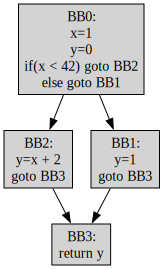

In [498]:
cfg = CFG([bb0, bb1, bb2, bb3])
cfg.print()
cfg.render()

In [499]:
cfg.compute_dominators()
for b, d in cfg.dominators.items():
    print(f"{b.name}: {[x.name for x in d]}")
print("-----------------")
cfg.compute_frontiers()
for b, d in cfg.frontiers.items():
    print(f"{b.name}: {[x.name for x in d]}")
cfg.calculate_phi()

BB0: ['BB0']
BB1: ['BB0', 'BB1']
BB2: ['BB2', 'BB0']
BB3: ['BB0', 'BB3']
-----------------
BB0: []
BB1: ['BB3']
BB2: ['BB3']
BB3: []


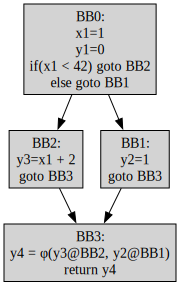

In [500]:
cfg.rename()
cfg.render()